In [ ]:
# Binomial test to find probability of success of circadian genes containing at least one eQTL 
# in a tissue, in a background of all introgressed GTEx eQTLs

In [ ]:
'''
GENERATE INTROGRESSED EQTL COUNT PER TISSUE
$ intersectBed -header -wa -wb -a /dors/capra_lab/data/eqtl/gtex/V8_GTEx_Analysis/bed/GTEx_v8_hg19.bed -b /dors/capra_lab/data/ancient_dna/archaic_hominin/browning18/introgressed_variants/introgressed_variants_browning18_hg19.bed > introgressed_gtex_v8_hg19.tab
$ cut -f1-8,12 introgressed_gtex_v8_hg19.tab > introgressed_gtex_v8_hg19.tab2
$ mv introgressed_gtex_v8_hg19.tab2 introgressed_gtex_v8_hg19.tab
$ sed 's/eQTL/eQTL\tRSID/1' introgressed_gtex_v8_hg19.tab > gtex_v8_hg19_introgressed.bed

GENERATE INTROGRESSED EQTL TISSUE COUNT PER GENE
cut -f4,8 gtex_v8_hg19_introgressed.bed | sort -k1 -u | cut -f1 | uniq -c > gtex_v8_hg19_introgressed_tissues_per_gene.txt
'''

In [16]:
CIRC_INTRO = '/dors/capra_lab/projects/neanderthal_circadian/bin/eqtl/gtex_v8_hg19_introgressed_in_circadian.bed'
#GTEX_PER_TISSUE = '/dors/capra_lab/data/eqtl/gtex/V8_GTEx_Analysis/bed/num_gtex_hg19_per_tissue.txt'
TISSUE_PER_GENE = 'count_num_genes_per_tissue_introgressed_gtex.txt'


In [17]:
import pandas as pd
import scipy.stats
import math
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

In [18]:
def load_and_parse_files(filename):
    file = open(filename).readlines()[1:]
    file = [n.strip().split() for n in file]
    df = pd.DataFrame(file, columns=['Variants','Tissues'])
    return df

In [19]:
# Tissues per gene in circadian introgressed set
circadian_introgressed = pd.read_csv(CIRC_INTRO, sep='\t')



In [35]:
circ_intro_genes_per_tissue = pd.DataFrame(circadian_introgressed[['gene_id','eQTL']].sort_values(
    by='eQTL').drop_duplicates().value_counts('eQTL'),columns=['Genes']).reset_index()

#introgressed_counts_per_tissue.rename(columns={'eQTL':'Tissues'},inplace=True)

In [36]:
# Genes per tissue in introgressed gtex
introgressed = open(TISSUE_PER_GENE).readlines()[:-1]
introgressed_df = pd.DataFrame([line.split() for line in introgressed],columns=['Genes','Tissues'])


In [37]:
introgressed_df = introgressed_df[~introgressed_df['Tissues'].isin(['eQTL'])]

In [45]:
introgressed_df.reset_index(inplace=True)

In [55]:
N = 128139
n = 246          # Trials; number of regions 3857
#max(circ_intro_genes_per_tissue['Tissues'])

In [56]:
# Add probability of success (p) column
introgressed_df['ProbSuccess'] = [int(number) / N for number in introgressed_df['Genes']]


In [57]:
# Binomial test

log2_list = []
binom_list = []
es_list = []

for i in range(len(circ_intro_genes_per_tissue)):
    # Success number
    s = circ_intro_genes_per_tissue['Genes'][i]
    # Generate probability of success (p)
    p = introgressed_df['ProbSuccess'][i]

    binomial_result = scipy.stats.binom_test(s, n, p)
    binom_to_list = binomial_result, circ_intro_genes_per_tissue['eQTL'][i]
    binom_list.append(binom_to_list)
    
    # And to quantify the effect size:
    effect_size = (int(s)/int(n)) / p
    es_to_list = effect_size, circ_intro_genes_per_tissue['eQTL'][i]
    es_list.append(es_to_list)

    # Take log2 value
    log2 = math.log(effect_size, 2)
    
    log_to_list = log2, circ_intro_genes_per_tissue['eQTL'][i]
    #a = binomial_result, gtex_sig_counts_per_tissue[1][i]
    
    log2_list.append(log_to_list)



In [58]:
# DF
#data_tuples = list(zip(log2_list,binom_list))
df_log2 = pd.DataFrame(log2_list, columns=['Log2','eQTL'])
df_binom = pd.DataFrame(binom_list, columns=['PVAL','eQTL'])

In [59]:
df = pd.merge(df_log2,df_binom, on='eQTL', how='outer')

In [60]:
df = df.sort_values(by='Log2')

In [61]:
# BONFERRONI
def myfunc(age, pval):
    if pval>0.05:
        age=0
    elif pval<=0.05 and pval>bonfe:
        age=1
    elif pval<=bonfe:
        age=2
    return age


In [62]:
bonfe = 0.05/49
df['Bonferroni'] = ''
df['Bonferroni'] = df.apply(lambda x: myfunc(x['Bonferroni'], x['PVAL']), axis=1)


"\nfor p in ax.patches:\n        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.05),\n                    ha='center', va='bottom', color= 'black')\n"

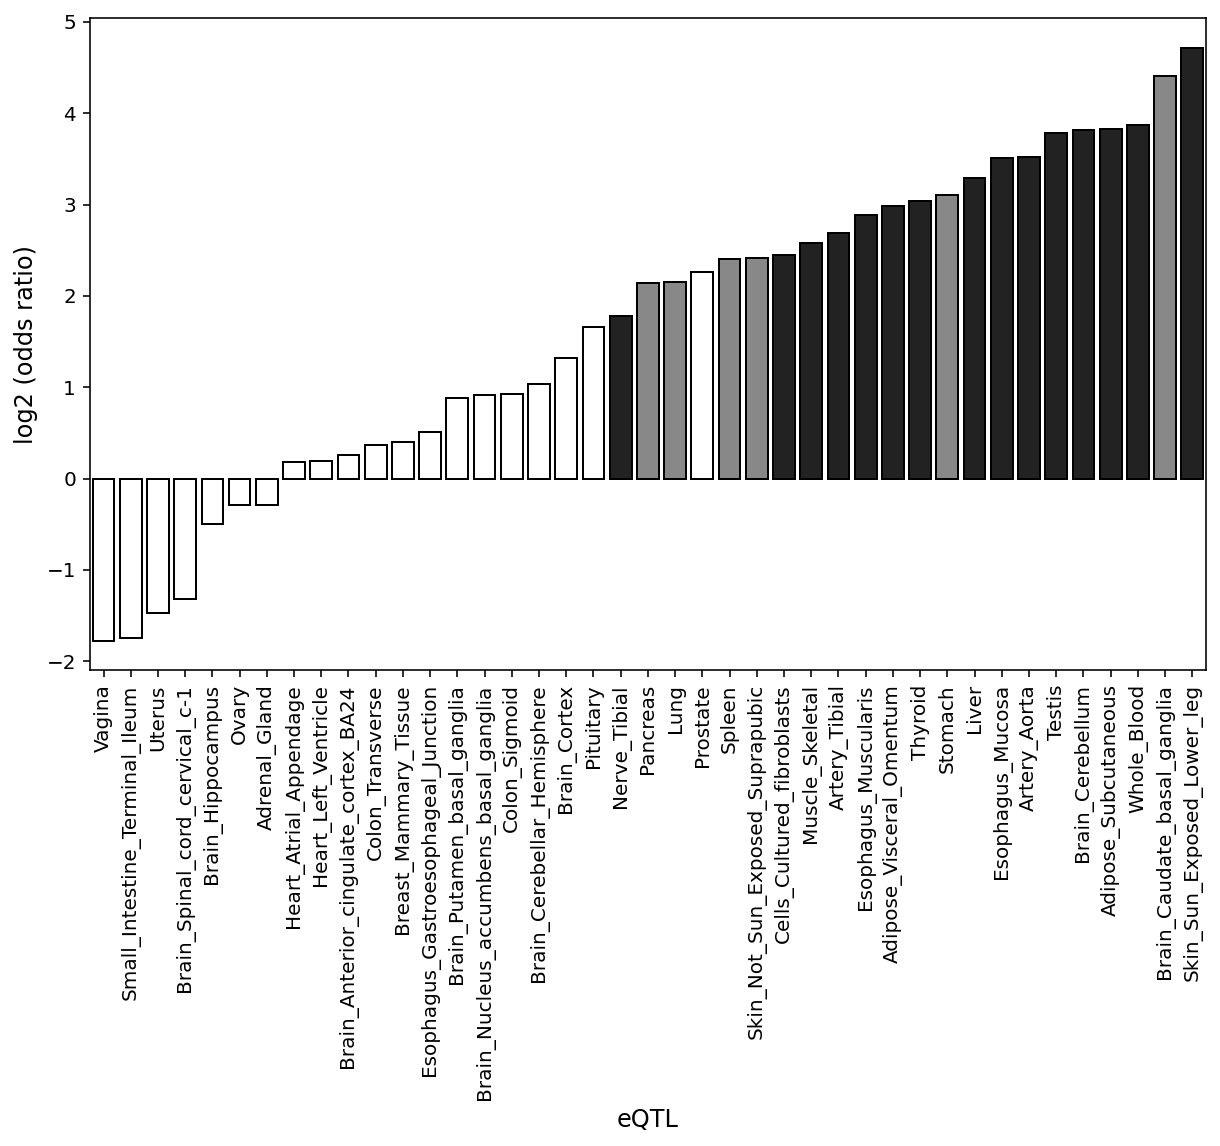

In [63]:
# Seaborn plot 
sns.set_palette(['#ffffff','#888888','#222222'], n_colors=100)
ax = sns.barplot(x='eQTL', y='Log2', hue='Bonferroni', data=df, dodge=False, edgecolor="black")
#ax = sns.barplot(x='Tissue', y='Log2', hue='PVAL', data=df, dodge=False, palette="viridis")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel("eQTL", fontsize = 12)
ax.set_ylabel("log2 (odds ratio)", fontsize = 12)

ax.legend_.remove()
plt.legend([],[], frameon=False)
#plt.savefig('gtex_sig_counts_per_tissue.pdf', bbox_inches='tight')  

'''
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.05),
                    ha='center', va='bottom', color= 'black')
'''

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 [Text(0, 0, 'Artery_Tibial'),
  Text(1, 0, 'Thyroid'),
  Text(2, 0, 'Adipose_Subcutaneous'),
  Text(3, 0, 'Cells_Cultured_fibroblasts'),
  Text(4, 0, 'Testis'),
  Text(5, 0, 'Nerve_Tibial'),
  Text(6, 0, 'Skin_Sun_Exposed_Lower_leg'),
  Text(7, 0, 'Whole_Blood'),
  Text(8, 0, 'Esophagus_Muscularis'),
  Text(9, 0, 'Muscle_Skeletal'),
  Text(10, 0, 'Lung'),
  Text(11, 0, 'Skin_Not_Sun_Exposed_Suprapubic'),
  Text(12, 0, 'Adipose_Visceral_Omentum'),
  Text(13, 0, 'Artery_Aorta'),
  Text(14, 0, 'Esophagus_Mucosa'),
  Text(15, 0, 'Pancreas'),
  Text(16, 0, 'Spleen'),
  Text(17, 0, 'Liver'),
  Text(18, 0, 'Brain_Cerebellum'),
  Text(19, 0, 'Brain_Cortex'),
  Text(20, 0, 'Breast_Mammary_Tissue'),
  Text(21, 0, 'Stomach'),
  Text(22, 0, 'Brain_Cerebellar_Hemisphere'),
  Text(23, 0, 'Brain_Putamen_basal_gan

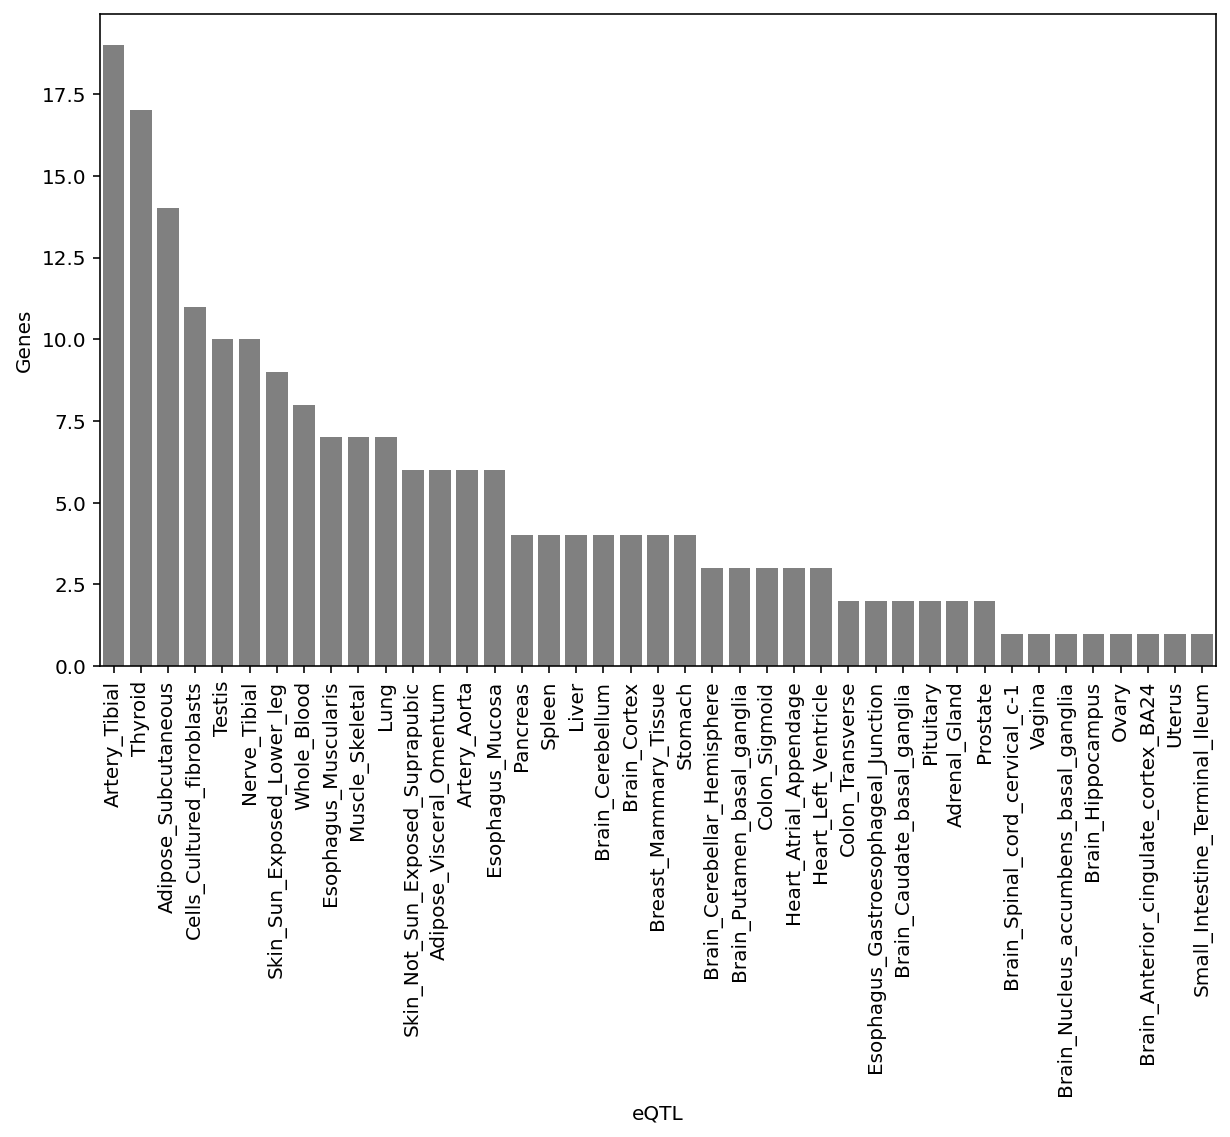

In [54]:
sns.barplot(x="eQTL", y="Genes", data=circ_intro_genes_per_tissue, color='gray')#palette="Wistia")
plt.xticks(rotation=90);
